In [317]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import cycle
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import r2_score, make_scorer
from scipy import stats
%matplotlib inline 

# 1. Preparing Data

### Loading HH Data

In [318]:
#hh_data = pd.read_csv("../Data/Intermediate_files/hh_village_coord_fcs.csv")

In [319]:
hh_data = pd.read_csv("../Data/Intermediate_files/hh_data_2011_cluster_minHH.csv")

### Loading CNN features

In [320]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features.csv")

In [321]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms.csv")

In [322]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGG16_block4_pool.csv")

In [323]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean.csv")

In [324]:
CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean_100imagescluster.csv")

### Merging

In [325]:
data=hh_data.merge(CNN_features,on=["i","j"])

In [326]:
data = data.sample(frac=1, random_state=1783).reset_index(drop=True) #Shuffling the data

In [327]:
start_features=len(hh_data.columns)+2

In [328]:
data_features=data.iloc[:,start_features:]

### Defining predictors and predicting variables

In [329]:
y = data["cons"].values #Average normalized consumption per cluster
y = y[y > 0]
y = np.log(y) #Log-normal distribution

In [330]:
y2 = data["poor_majority"] #Dummy variable for majority of poor in the cluster

In [331]:
X=data_features.values

In [332]:
X.shape

(309, 4096)

In [333]:
y.shape

(309,)

(array([  3.,  14.,  47.,  85.,  70.,  35.,  28.,  20.,   5.,   2.]),
 array([-0.40340905, -0.02670821,  0.34999262,  0.72669345,  1.10339428,
         1.48009511,  1.85679595,  2.23349678,  2.61019761,  2.98689844,
         3.36359927]),
 <a list of 10 Patch objects>)

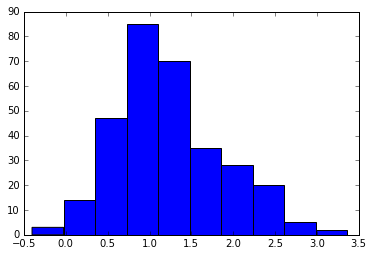

In [334]:
plt.hist(y)

In [335]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.431038,0.077483,0.092553,0.261941,0.363410,0.048217,0.380750,0.023896,0.356066,0.007566,...,0.053955,0.530246,0.000108,0.893542,0.122487,0.313626,0.102110,0.167905,0.272255,0.027515
1,0.428459,0.063750,0.089325,0.252737,0.419013,0.048156,0.385741,0.023259,0.315964,0.008038,...,0.030032,0.528919,0.001333,0.958313,0.161219,0.364889,0.127361,0.173445,0.252023,0.043384
2,0.385637,0.086354,0.120632,0.282507,0.445009,0.060340,0.520475,0.096587,0.366569,0.027334,...,0.085380,0.731123,0.002758,1.004187,0.188414,0.319978,0.085559,0.159509,0.308257,0.040254
3,0.353024,0.039933,0.009876,0.182106,0.407607,0.037106,0.432121,0.004294,0.104090,0.005595,...,0.016546,0.570199,0.000000,1.113124,0.152739,0.482899,0.049401,0.136552,0.152211,0.018855
4,0.327865,0.060838,0.028629,0.165845,0.335859,0.032065,0.372110,0.009725,0.125366,0.016100,...,0.023363,0.513886,0.000000,0.920871,0.179212,0.421113,0.077887,0.131257,0.144615,0.041710


# 2. Predicting Continuous Indicator

In [336]:
model=Ridge()

In [337]:
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1673)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=75788)

In [338]:
def r2_pearson(ground_truth, predictions):
    r2_pearson=stats.pearsonr(ground_truth, predictions)[0] ** 2
    return r2_pearson
r2_pearson = make_scorer(r2_pearson, greater_is_better=True)

In [339]:
#Inner cross-validation loop
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=inner_cv, scoring=r2_pearson)

## From PCA Components

In [340]:
alphas = np.array([0.01,0.1,1,5,10,20,30,40,50])

In [341]:
pca = PCA(n_components=10)

In [342]:
pca.fit(data_features.transpose())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [343]:
eigenvectors=pca.components_

In [344]:
X2 = pd.DataFrame(np.transpose(eigenvectors))
X2.shape

(309, 10)

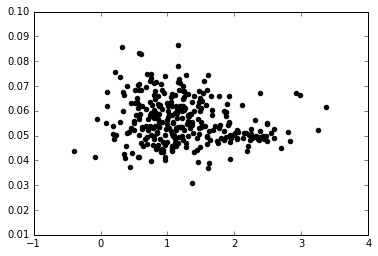

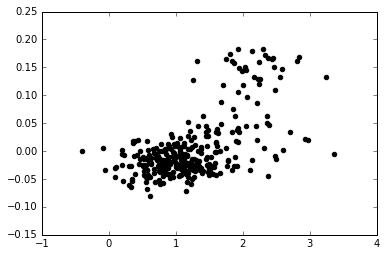

In [345]:
for i in range(2):
    plt.figure()
    plt.scatter(y, eigenvectors[i],  color='black')

In [346]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

r2 (pearson): 0.44 (+/- 0.07)


In [347]:
# Outer Loop with R2
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

R2: 0.42 (+/- 0.08)


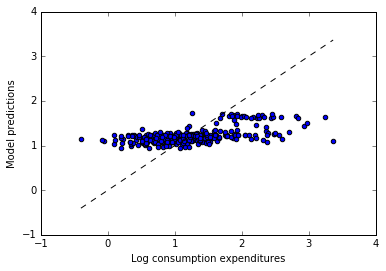

In [348]:
y_hat = cross_val_predict(clf, X2, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

## From all (4096) features

In [349]:
alphas = np.array([1,5,10,20,30,40,50])

In [350]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

r2 (pearson): 0.44 (+/- 0.07)


In [351]:
r2

array([ 0.41252763,  0.43675519,  0.38383315,  0.48026134,  0.47227525])

In [352]:
# Outer Loop with R2
R2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: 0.42 (+/- 0.08)


In [353]:
R2

array([ 0.40299439,  0.41051703,  0.3582438 ,  0.46818944,  0.46583258])

In [354]:
neg_mean_squared_error = cross_val_score(clf, X, y, cv=outer_cv,scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (-neg_mean_squared_error.mean(), neg_mean_squared_error.std() * 2)) 

neg_mean_squared_error: 0.23 (+/- 0.10)


In [355]:
-neg_mean_squared_error

array([ 0.24690297,  0.31071898,  0.23947061,  0.20027002,  0.16744521])

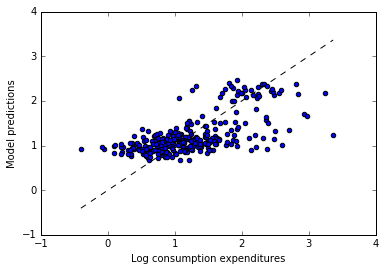

In [356]:
y_hat = cross_val_predict(clf, X, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

In [357]:
r2_score(y,y_hat)

0.42608753076829609

In [358]:
stats.pearsonr(y,y_hat)[0] ** 2

0.42620539453641487

# 3. Predicting Dummy Indicator from all features

In [359]:
model = linear_model.LogisticRegression(penalty="l2")
model.fit(X, y2) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [360]:
cv = KFold(n_splits=10, shuffle=True, random_state=167)

In [361]:
accuracy = cross_val_score(model, X, y2, cv=cv)
f1 = cross_val_score(model, X, y2, cv=cv,scoring='f1')
precision = cross_val_score(model, X, y2, cv=cv,scoring='precision')
recall= cross_val_score(model, X, y2, cv=cv,scoring='recall')
auc= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')
confusion= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')

In [362]:
scores = cross_val_score(model, X, y2, cv=10,scoring='precision')
accuracy_print=("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
f1_print=("F1: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))
precision_print=("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall_print=("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
auc_print=("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))
print(os.linesep.join([accuracy_print,f1_print,precision_print,recall_print,auc_print]))

Accuracy: 0.79 (+/- 0.12)
F1: 0.47 (+/- 0.22)
Precision: 0.68 (+/- 0.34)
Recall: 0.38 (+/- 0.25)
AUC: 0.80 (+/- 0.14)


In [363]:
y2.describe()

count    309.000000
mean       0.258900
std        0.438741
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: poor_majority, dtype: float64